# Classification de feuilles d'arbres

C'est ici un challenge Kaggle (https://www.kaggle.com/c/leaf-classification/) dont l'objectif est d'identifier le type de plante (99 au total) à partir d'images de feuilles et de caractéristiques extraites.  
Pour ça on va utiliser du Deep-Learning avec Keras.  
<img src="files/keras.png" alt="drawing" width="500">

Crédits : https://www.kaggle.com/abhmul/keras-convnet-lb-0-0052-w-visualization

# Import des packages que l'on va utiliser

In [2]:
%matplotlib inline
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import pickle
import cv2
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook

# Keras stuff
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import TensorBoard

In [3]:
import keras
print('The keras version is {}.'.format(keras.__version__))
import tensorflow as tf
print('The tensorflow version is {}.'.format(tf.__version__))
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The keras version is 2.7.0.
The tensorflow version is 2.7.0.
The scikit-learn version is 1.0.


### On fixe certains paramètres et l'aléatoire

In [4]:
root = os.getcwd()
np.random.seed(25)
split_random_state = 5
split = .85

# Chargement des données

In [5]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

In [6]:
def load_numeric_training(standardize=True):
    """
    Loads the pre-extracted features for the training data
    and returns a tuple of the image ids, the data, and the labels
    """
    # Read data from the CSV file
    data = pd.read_csv(os.path.join(root, 'data/train.csv'))
    ID = data.pop('id')

    # Since the labels are textual, so we encode them categorically
    y = data.pop('species')
    y = LabelEncoder().fit(y).transform(y)
    # standardize the data by setting the mean to 0 and std to 1
    X = StandardScaler().fit(data).transform(data) if standardize else data.values

    return ID, X, y


def load_numeric_test(standardize=True):
    """
    Loads the pre-extracted features for the test data
    and returns a tuple of the image ids, the data
    """
    test = pd.read_csv(os.path.join(root, 'data/test.csv'))
    ID = test.pop('id')
    # standardize the data by setting the mean to 0 and std to 1
    test = StandardScaler().fit(test).transform(test) if standardize else test.values
    return ID, test


def resize_img(img, max_dim=128):
    """
    Resize the image to so the maximum side is of size max_dim
    Returns a new image of the right size
    """
    # Get the axis with the larger dimension
    max_ax = max((0, 1), key=lambda i: img.size[i])
    # Scale both axes so the image's largest dimension is max_dim
    scale = max_dim / float(img.size[max_ax])
    return img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))


def load_image_data(ids, max_dim=128, center=True):
    """
    Takes as input an array of image ids and loads the images as numpy
    arrays with the images resized so the longest side is max-dim length.
    If center is True, then will place the image in the center of
    the output array, otherwise it will be placed at the top-left corner.
    """
    # Initialize the output array
    # NOTE: Theano users comment line below and
    X = np.empty((len(ids), max_dim, max_dim, 1))
    # X = np.empty((len(ids), 1, max_dim, max_dim)) # uncomment this
    for i, idee in enumerate(tqdm_notebook(list(ids))):
        # Turn the image into an array
        #x = resize_img(load_img(os.path.join(root, 'data/images', str(idee) + '.jpg'), grayscale=True), max_dim=max_dim)
        
        x = load_img(os.path.join(root, 'data/images', str(idee) + '.jpg'), grayscale=True)     
        x = np.asarray(x, dtype=np.uint8)        
        x = cv2.resize(x, (max_dim, max_dim), interpolation=cv2.INTER_LINEAR)
        #x = cv2.Canny(x,100,200) # Les 100 et 200 sont des seuils du filtre à régler
        x = img_to_array(x)
        
        # Get the corners of the bounding box for the image
       
        length = x.shape[0]
        width = x.shape[1]
        
        if center:
            h1 = int((max_dim - length) / 2)
            h2 = h1 + length
            w1 = int((max_dim - width) / 2)
            w2 = w1 + width
        else:
            h1, w1 = 0, 0
            h2, w2 = (length, width)
        # Insert into image matrix
        X[i, h1:h2, w1:w2, 0:1] = x
        
    # Scale the array values so they are between 0 and 1
    return np.around(X / 255.0)


def load_train_data(split=split, random_state=None):
    """
    Loads the pre-extracted feature and image training data and
    splits them into training and cross-validation.
    Returns one tuple for the training data and one for the validation
    data. Each tuple is in the order pre-extracted features, images,
    and labels.
    """
    # Load the pre-extracted features
    ID, X_num_tr, y = load_numeric_training()
    # Load the image data
    X_img_tr = load_image_data(ID)
    # Split them into validation and cross-validation
    sss = StratifiedShuffleSplit(n_splits=1, train_size=split, random_state=random_state)
    train_ind, test_ind = next(sss.split(X_num_tr, y))
    X_num_val, X_img_val, y_val = X_num_tr[test_ind], X_img_tr[test_ind], y[test_ind]
    X_num_tr, X_img_tr, y_tr = X_num_tr[train_ind], X_img_tr[train_ind], y[train_ind]
    return (X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val)


def load_test_data():
    """
    Loads the pre-extracted feature and image test data.
    Returns a tuple in the order ids, pre-extracted features,
    and images.
    """
    # Load the pre-extracted features
    ID, X_num_te = load_numeric_test()
    # Load the image data
    X_img_te = load_image_data(ID)
    return ID, X_num_te, X_img_te

In [7]:
print('Loading the training data...')
(X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val) = load_train_data(random_state=split_random_state)
y_tr_cat = to_categorical(y_tr)
y_val_cat = to_categorical(y_val)
print('Training data loaded!')

Loading the training data...


/tmp/ipykernel_120804/3251650489.py:54: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, idee in enumerate(tqdm_notebook(list(ids))):


  0%|          | 0/990 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Training data loaded!


# Les features numériques

In [8]:
train = pd.read_csv(os.path.join(root, 'data/train.csv'))
train.pop('id')
train.head()

,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [9]:
train.describe()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,0.007167,0.018639,...,0.036501,0.005024,0.015944,0.011586,0.016108,0.014017,0.002688,0.020291,0.008989,0.019420
std,0.019739,0.038855,0.025847,0.028411,0.018390,0.052030,0.017511,0.002743,0.008933,0.016071,...,0.063403,0.019321,0.023214,0.025040,0.015335,0.060151,0.011415,0.039040,0.013791,0.022768
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001953,0.001953,0.013672,0.005859,0.001953,0.000000,0.005859,0.000000,0.001953,0.005859,...,0.000000,0.000000,0.000977,0.000000,0.004883,0.000000,0.000000,0.000000,0.000000,0.000977
50%,0.009766,0.011719,0.025391,0.013672,0.007812,0.015625,0.015625,0.000000,0.005859,0.015625,...,0.004883,0.000000,0.005859,0.000977,0.012695,0.000000,0.000000,0.003906,0.002930,0.011719
75%,0.025391,0.041016,0.044922,0.029297,0.017578,0.056153,0.029297,0.000000,0.007812,0.027344,...,0.043701,0.000000,0.022217,0.009766,0.021484,0.000000,0.000000,0.023438,0.012695,0.029297
max,0.087891,0.205080,0.156250,0.169920,0.111330,0.310550,0.091797,0.031250,0.076172,0.097656,...,0.429690,0.202150,0.172850,0.200200,0.106450,0.578130,0.151370,0.375980,0.086914,0.141600


# Correlation map

In [10]:
corr = train.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


<AxesSubplot:>

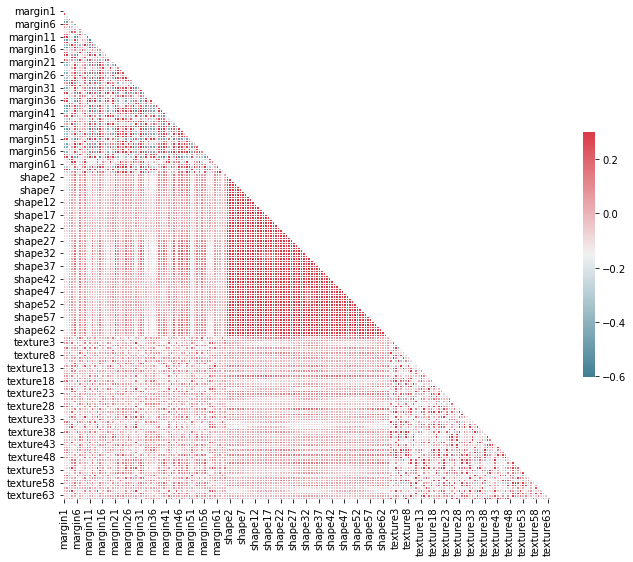

In [11]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

# Entrainement rapide d'une régression logisitique

In [12]:
t = time.time()
warnings.filterwarnings("ignore", category=FutureWarning) # Some iterations are not convering because of not really realistic combinations of penalty
clf = LogisticRegression()
clf.fit(X_num_tr, y_tr)
print('Time elapsed :', round(time.time() - t,2), 'seconds')

Time elapsed : 2.1 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
y_pred_val = clf.predict(X_num_val)
print('Loss cross entropy :', cross_entropy(y_pred_val, y_val))
print('Précision :', accuracy_score(y_val, y_pred_val))

Loss cross entropy : -4.976226812466664e-08
Précision : 0.9932885906040269


t = time.time()
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning) # Some iterations are not convering because of not really realistic combinations of penalty
clf = LogisticRegressionCV(Cs = np.logspace(-4, 4, num=10), cv=3, penalty = 'elasticnet', solver='saga', max_iter=200, l1_ratios=np.linspace(0, 1, num=10), n_jobs=-1)
clf.fit(X_num_tr, y_tr)
print('Time elapsed :', round(time.time() - t,2), 'seconds')

In [14]:
y_pred_val = clf.predict(X_num_val)
print('Loss cross entropy :', cross_entropy(y_pred_val, y_val))
print('Précision :', accuracy_score(y_val, y_pred_val))

Loss cross entropy : -4.976226812466664e-08
Précision : 0.9932885906040269


In [15]:
f = open('weights/RegLog.pckl', 'wb')
pickle.dump(clf, f)
f.close()

In [16]:
f = open('weights/RegLog.pckl', 'rb')
clf = pickle.load(f)
f.close()

C'est bien et explicatif mais sans doute que l'on peut faire mieux en utilisant aussi les images !!

## Visualisation de quelques images

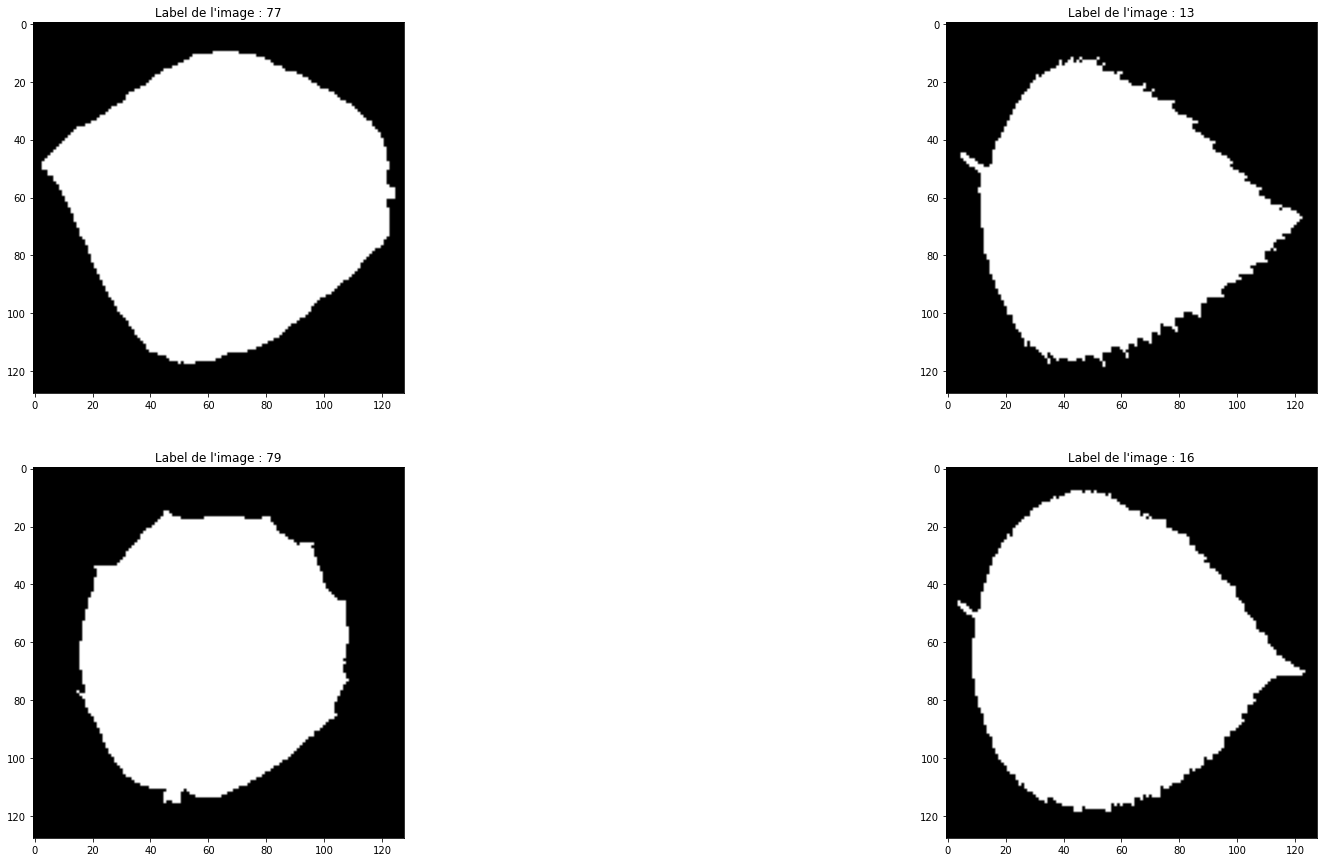

In [17]:
plt.figure(figsize=(30,15))

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(X_img_tr[i].reshape((128,128)), 'gray')
    plt.title('Label de l\'image : ' + str(y_tr[i]))

In [18]:
print('Nombre d\'images d\'entrainement :% d.' %(len(X_img_tr)))

Nombre d'images d'entrainement : 841.


# Data Augmentation

On va utiliser un truc, classique avec les CNN, pour agrandir notre jeu de donnéres et améliorer la robustesse de notre classifieur.

On va faire des rotations, des retournements horizontaux et verticaux, des zooms aléatoires, etc... Avec des images de couleur on peut aussi jouer sur le contraste, correction gamma etc..


**NOTE:** Ce n'est pas non plus magique vu qu'on ajoute aucune information extérieure.

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img

# Une toute petite modifs pour toujours avoir accès aux indices des images
class ImageDataGenerator2(ImageDataGenerator):
    def flow(self, x, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='jpeg'):
        return NumpyArrayIterator2(
            x, y, self,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format)


class NumpyArrayIterator2(NumpyArrayIterator):
    def next(self):
        # for python 2.x.
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch
        # see http://anandology.com/blog/using-iterators-and-generators/
        with self.lock:
        # We changed index_array to self.index_array
            self.index_array = np.random.choice(range(len(self.x)), size = self.batch_size, replace= False)  #  next(self.index_generator)
        #print(self.index_array)
        current_index = 5
        current_batch_size = self.batch_size 
        # The transformation of images is not under thread lock so it can be done in parallel
        batch_x = np.zeros(tuple([current_batch_size] + list(self.x.shape)[1:]))
        for i, j in enumerate(self.index_array):
            x = self.x[j]
            x = self.image_data_generator.random_transform(x.astype('float32'))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
        if self.save_to_dir:
            for i in range(current_batch_size):
                img = array_to_img(batch_x[i], self.dim_ordering, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        if self.y is None:
            return batch_x
        batch_y = self.y[self.index_array]
        return batch_x, batch_y

In [20]:
print('Creating Data Augmenter...')
imgen = ImageDataGenerator2(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest')
imgen_train = imgen.flow(X_img_tr, y_tr_cat, seed=24)
print('Finished making data augmenter...')

Creating Data Augmenter...
Finished making data augmenter...


# Combinaisons des features du CNN et des features extraites

Ca y est toutes nos données sont prêtes, on va pouvoir passer au modèle.

## Keras Functional API

Il existe ausi une ```Keras's Sequential API```, encore plus simple mais nous ne pouvons pas l'utiliser ici à cause de cette combinaison entre réseau CNN et ajout des features pré-extraites.

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, Input, concatenate, LeakyReLU
from tensorflow.keras.layers import BatchNormalization

In [22]:
def combined_model():
    
    image = Input(shape=(128, 128, 1), name='image')
    x = Conv2D(8, (5, 5), input_shape=(128, 128, 1), padding='same')(image)
    x = (Activation('relu'))(x)
    x = (Dropout(.2))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    x = (Conv2D(32, (5, 5), padding='same'))(x)
    x = (Activation('relu'))(x)
    x = (Dropout(.2))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    x = Flatten()(x)
    numerical = Input(shape=(192,), name='numerical')
    # Concatenate the output of our convnet with our pre-extracted feature input
    concatenated = concatenate([x, numerical])

    x = Dense(100, activation='relu')(concatenated)
    x = Dropout(.2)(x)

    out = Dense(99, activation='softmax')(x)
    model = Model(inputs=[image, numerical], outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
    
    return model

In [58]:
model = combined_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 128, 128, 8)  208         ['image[0][0]']                  
                                                                                                  
 activation_2 (Activation)      (None, 128, 128, 8)  0           ['conv2d_2[0][0]']               
                                                                                                  
 dropout_3 (Dropout)            (None, 128, 128, 8)  0           ['activation_2[0][0]']     

Pour que ça tourne vite il faut faire tourner sur GPU !

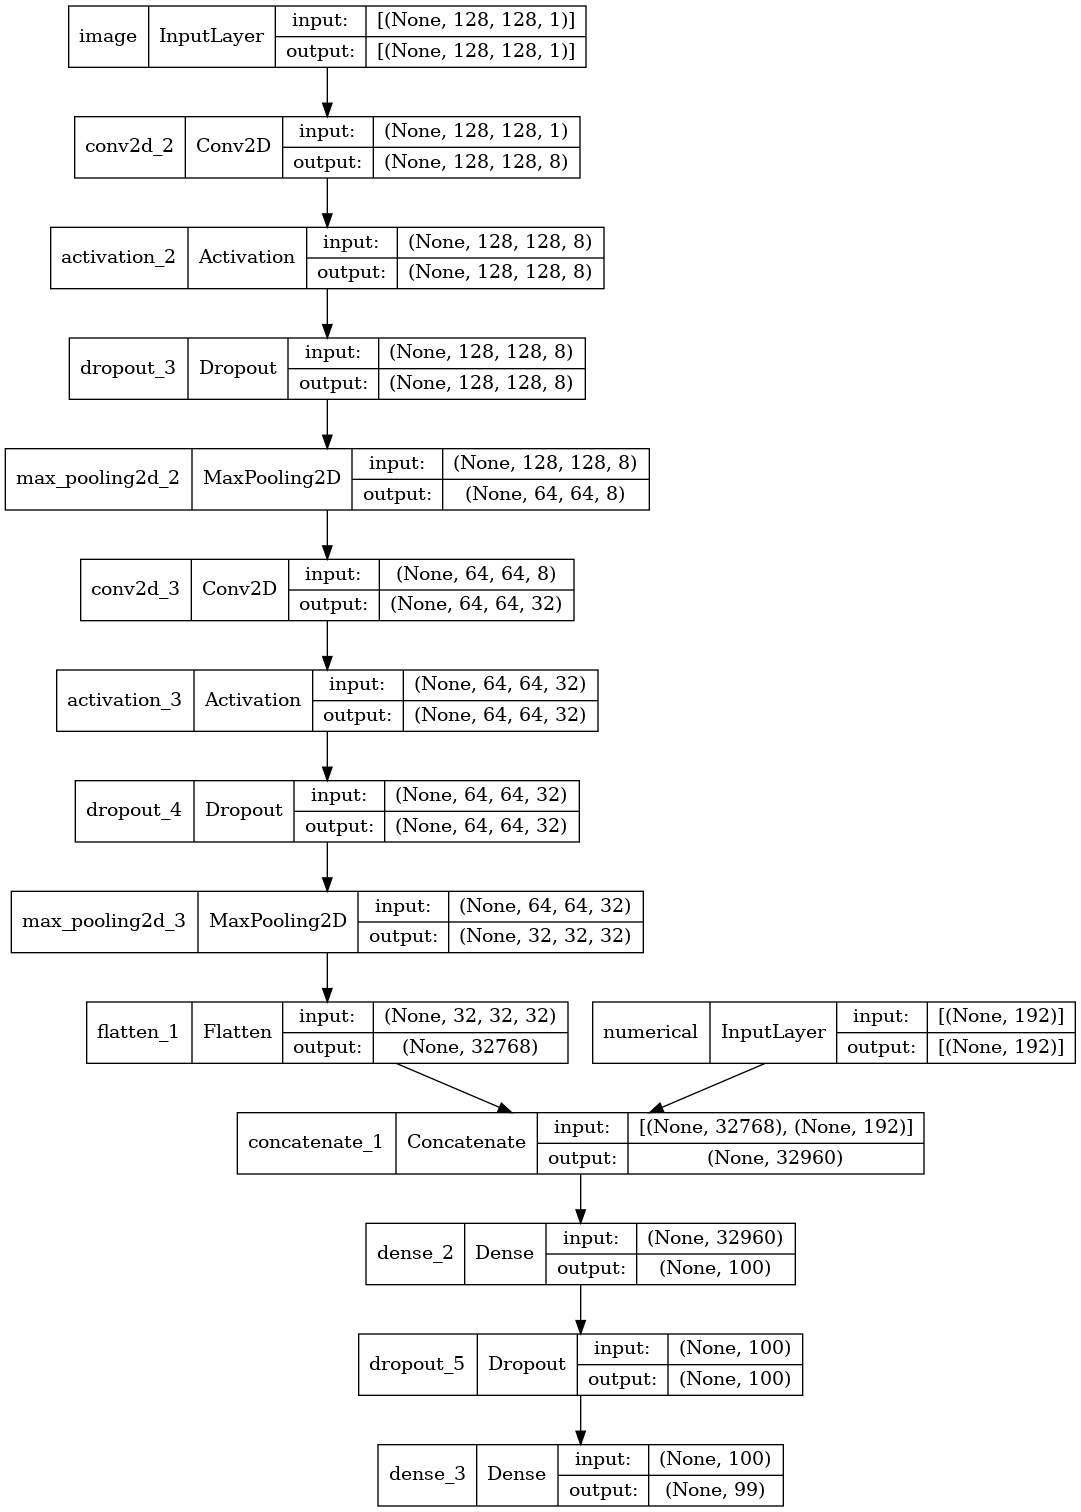

In [59]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='files/model_plot.png', show_shapes=True, show_layer_names=True)

<img src="files/model_plot.png" alt="drawing" width="500" >

In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model


def combined_generator(imgen, X):
    """
    A generator to train our keras neural network. It
    takes the image augmenter generator and the array
    of the pre-extracted features.
    It yields a minibatch and will run indefinitely
    """
    while True:
        for i in range(X.shape[0]):
            # Get the image batch and labels
            batch_img, batch_y = next(imgen)
            # We can now access the indicies
            # of the images that imgen gave us.
            x = X[imgen.index_array]
            yield [batch_img, x], batch_y
            
batch_size = 128
epochs = 50

In [61]:
comb = combined_generator(imgen_train, X_num_tr)

In [62]:
im, tr = next(comb)

In [63]:
%%time
best_model_file = "weights/leafnet.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=0, save_best_only=True)
tbCallBack = TensorBoard(log_dir='./graph', histogram_freq=1, write_graph=True, write_images=True)

history = model.fit(combined_generator(imgen_train, X_num_tr),
                              steps_per_epoch=np.ceil(X_num_tr.shape[0] / batch_size),
                              epochs=epochs,
                              validation_data=([X_img_val, X_num_val], y_val_cat),
                              verbose=1,
                              callbacks=[best_model,tbCallBack ])

Epoch 1/50
7/7 [==============================] - 2s 233ms/step - loss: 4.5453 - accuracy: 0.0446 - val_loss: 4.4616 - val_accuracy: 0.0604
Epoch 2/50
7/7 [==============================] - 1s 213ms/step - loss: 4.3824 - accuracy: 0.1027 - val_loss: 4.2723 - val_accuracy: 0.1409
Epoch 3/50
7/7 [==============================] - 1s 212ms/step - loss: 4.1880 - accuracy: 0.1607 - val_loss: 4.0653 - val_accuracy: 0.1879
Epoch 4/50
7/7 [==============================] - 1s 206ms/step - loss: 4.0121 - accuracy: 0.1741 - val_loss: 3.7969 - val_accuracy: 0.2282
Epoch 5/50
7/7 [==============================] - 1s 212ms/step - loss: 3.7004 - accuracy: 0.2455 - val_loss: 3.5206 - val_accuracy: 0.2953
Epoch 6/50
7/7 [==============================] - 1s 219ms/step - loss: 3.4579 - accuracy: 0.2455 - val_loss: 3.2262 - val_accuracy: 0.3691
Epoch 7/50
7/7 [==============================] - 1s 210ms/step - loss: 3.0253 - accuracy: 0.3750 - val_loss: 2.9252 - val_accuracy: 0.4295
Epoch 8/50
7/7 [====

In [64]:
y_pred_val = model.predict([X_img_val, X_num_val])
y_pred_val = np.argmax(y_pred_val,axis=1)
print('Loss cross entropy :', cross_entropy(y_pred_val, y_val))
print('Précision :', accuracy_score(y_val, y_pred_val))

Loss cross entropy : -4.976226812466664e-08
Précision : 0.9731543624161074


# Visualisation

Bon on peut quand même se demander ce qui a été appris par le CNN et que ces features ont un sens ! On va donc visualiser quelques couches cachées.  
On va donc prendre quelques images du set de validation, et on va les faire passer à travers le réseau pour visualiser les résultats de différents filtrages à l'intérieur du CNN pour voir quelles parties sont activées.  
Dans notre architecture, il y a 8 filtres pour la première couche et 32 pour la seconde donc 40 images filtrées au total !

In [27]:
import pandas as pd
LABELS = sorted(pd.read_csv(os.path.join(root, 'data/train.csv')).species.unique())

In [66]:
NUM_LEAVES = 3
model_fn = 'weights/leafnet.h5'
# Load the best model
model = load_model(model_fn)

# Get the convolutional layers
conv_layers = [layer for layer in model.layers if isinstance(layer, MaxPooling2D)]

# Pick random images to visualize
imgs_to_visualize = np.random.choice(np.arange(0, len(X_img_val)), NUM_LEAVES)

# Use a keras function to extract the conv layer data
convout_func = Model(inputs=model.inputs, outputs=model.layers[1].output)  # K.function([model.layers[0].input, K.learning_phase()], [layer.output for layer in conv_layers])
conv_imgs_filts = convout_func([X_img_val[imgs_to_visualize], 0])
# Also get the prediction so we know what we predicted
predictions = convout_func.predict([X_img_val[imgs_to_visualize], X_num_val[imgs_to_visualize]])
pred = model.predict([X_img_val[imgs_to_visualize], X_num_val[imgs_to_visualize]])

In [67]:
def show_filtered(imgs_to_visualize, idx):
    ix = 1
    img_to_visualize = imgs_to_visualize[idx]
    top3_ind = pred[idx].argsort()[-3:]
    top3_species = np.array(LABELS)[top3_ind]
    top3_preds = pred[idx][top3_ind]
    actual = LABELS[y_val[img_to_visualize]]
    print("Top 3 Predictions:")
    for i in range(2, -1, -1):
        print("\t%s: %s" % (top3_species[i], top3_preds[i]))
    print("\nActual: %s" % actual)
    for _ in range(2):
        for _ in range(4):
            # specify subplot and turn of axis
            ax = plt.subplot(2, 4, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(predictions[idx, :, :, ix-1], cmap='gray')
            ix += 1

Top 3 Predictions:
	Quercus_Dolicholepis: 0.8961257
	Eucalyptus_Glaucescens: 0.037140325
	Quercus_Crassifolia: 0.01699054

Actual: Quercus_Dolicholepis


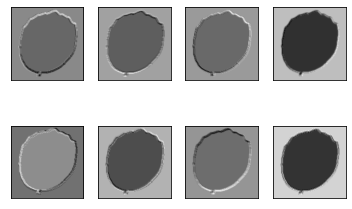

In [68]:
show_filtered(imgs_to_visualize, 0)

Top 3 Predictions:
	Quercus_Imbricaria: 0.9552225
	Viburnum_Tinus: 0.0106641855
	Quercus_x_Turneri: 0.0097197

Actual: Quercus_Imbricaria


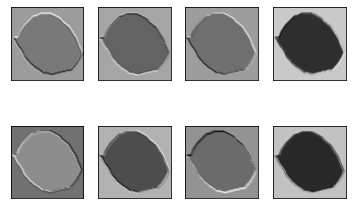

In [69]:
show_filtered(imgs_to_visualize, 1)

Top 3 Predictions:
	Ulmus_Bergmanniana: 0.97505194
	Salix_Fragilis: 0.0112208845
	Betula_Austrosinensis: 0.0054916283

Actual: Ulmus_Bergmanniana


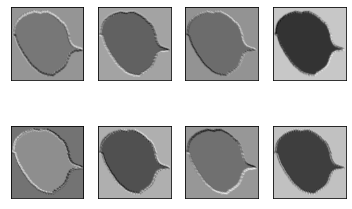

In [70]:
show_filtered(imgs_to_visualize, 2)

In [71]:
del model

# API avec Flask
Web micro-framework en Python (utilisé par Pinterest et Linkedin d'après Wikipedia).  

<img src="files/flask.png" alt="drawing" width="500">  


* Léger
* Rapide
* Facile d'utilisation  


Ici on va faire seulement le back-end ! Du dev supplémentaire serait nécessaire pour rajouter un front-end.

In [ ]:
!cd api && nohup python3 deploy.py

nohup: les entrées sont ignorées et la sortie est ajoutée à 'nohup.out'


In [25]:
%%time
import requests
import json

headers = {"Content-Type": "application/json"}
payload = [X_img_val[93:94].tolist(), X_num_val[93:94].tolist()]

r = requests.post("http://0.0.0.0:5001/predict", json=payload, headers=headers)
response = json.loads(r.text)
print(response['success'])

True
CPU times: user 13.2 ms, sys: 4.96 ms, total: 18.2 ms
Wall time: 1.17 s


In [28]:
response['prediction'] = response['prediction'].replace('[[','')
response['prediction'] = response['prediction'].replace(']]','')
predictions = np.array(response['prediction'].split(),dtype=float)
top3_ind = predictions.argsort()[-3:]
top3_species = np.array(LABELS)[top3_ind]
top3_preds = predictions[top3_ind]
# Display the top 3 predictions and the actual species
print("Top 3 Predicitons:")
for i in range(2, -1, -1):
    print("\t%s: %s" % (top3_species[i], top3_preds[i]))

Top 3 Predicitons:
	Tilia_Platyphyllos: 0.817175627
	Celtis_Koraiensis: 0.128483415
	Pterocarya_Stenoptera: 0.0104533406
